In [2]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
   .master("local") \
   .appName("Natural Language Processing") \
   .config("spark.executor.memory", "6gb") \
   .getOrCreate()

In [4]:
df = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('TherapyBotSession.csv')

In [5]:
df.show()

+---+---------------+--------------------+----+----+----+----+
| id|          label|                chat| _c3| _c4| _c5| _c6|
+---+---------------+--------------------+----+----+----+----+
|  1|       escalate|I had a friend th...|null|null|null|null|
|  2|       escalate|"My friend dealt ...|null|null|null|null|
|  3|       escalate|Friend who had bi...|null|null|null|null|
|  4|do_not_escalate|Over the internet...|null|null|null|null|
|  5|       escalate|Having gone throu...|null|null|null|null|
|  6|       escalate|My now girlfriend...|null|null|null|null|
|  7|do_not_escalate|"Only really one ...|null|null|null|null|
|  8|do_not_escalate|Now that I've bee...|null|null|null|null|
|  9|do_not_escalate|I've always been ...|null|null|null|null|
| 10|       escalate|I feel completely...|null|null|null|null|
| 11|do_not_escalate|Took a week off w...|null|null|null|null|
| 12|       escalate|One of my best fr...|null|null|null|null|
| 13|       escalate|I've had some fri...|null|null|nul

In [6]:
df = df.select('id', 'label', 'chat')

In [7]:
df.show()

+---+---------------+--------------------+
| id|          label|                chat|
+---+---------------+--------------------+
|  1|       escalate|I had a friend th...|
|  2|       escalate|"My friend dealt ...|
|  3|       escalate|Friend who had bi...|
|  4|do_not_escalate|Over the internet...|
|  5|       escalate|Having gone throu...|
|  6|       escalate|My now girlfriend...|
|  7|do_not_escalate|"Only really one ...|
|  8|do_not_escalate|Now that I've bee...|
|  9|do_not_escalate|I've always been ...|
| 10|       escalate|I feel completely...|
| 11|do_not_escalate|Took a week off w...|
| 12|       escalate|One of my best fr...|
| 13|       escalate|I've had some fri...|
| 14|do_not_escalate|Haha. In eight gr...|
| 15|do_not_escalate|Some of my friend...|
| 16|       escalate|I feel like depre...|
| 17|       escalate|i've had a couple...|
| 18|       escalate|I will always lis...|
| 19|do_not_escalate|A lot for my frie...|
| 20|do_not_escalate|When my friend ne...|
+---+------

In [8]:
df.groupBy("label") \
    .count() \
    .orderBy("count", ascending = False) \
    .show()

+---------------+-----+
|          label|count|
+---------------+-----+
|do_not_escalate|   65|
|       escalate|   35|
+---------------+-----+



In [9]:
import pyspark.sql.functions as F
df = df.withColumn('word_count',F.size(F.split(F.col('chat'),' ')))

In [10]:
df.show()

+---+---------------+--------------------+----------+
| id|          label|                chat|word_count|
+---+---------------+--------------------+----------+
|  1|       escalate|I had a friend th...|       304|
|  2|       escalate|"My friend dealt ...|       184|
|  3|       escalate|Friend who had bi...|        90|
|  4|do_not_escalate|Over the internet...|        88|
|  5|       escalate|Having gone throu...|        71|
|  6|       escalate|My now girlfriend...|        73|
|  7|do_not_escalate|"Only really one ...|        74|
|  8|do_not_escalate|Now that I've bee...|        62|
|  9|do_not_escalate|I've always been ...|        60|
| 10|       escalate|I feel completely...|        56|
| 11|do_not_escalate|Took a week off w...|        60|
| 12|       escalate|One of my best fr...|        59|
| 13|       escalate|I've had some fri...|        50|
| 14|do_not_escalate|Haha. In eight gr...|        55|
| 15|do_not_escalate|Some of my friend...|        49|
| 16|       escalate|I feel 

In [11]:
df.groupBy('label')\
    .agg(F.avg('word_count').alias('avg_word_count'))\
    .orderBy('avg_word_count', ascending = False) \
    .show()

+---------------+-----------------+
|          label|   avg_word_count|
+---------------+-----------------+
|       escalate|             44.0|
|do_not_escalate|20.29230769230769|
+---------------+-----------------+



In [12]:
df_plot = df.select('id', 'word_count').toPandas()

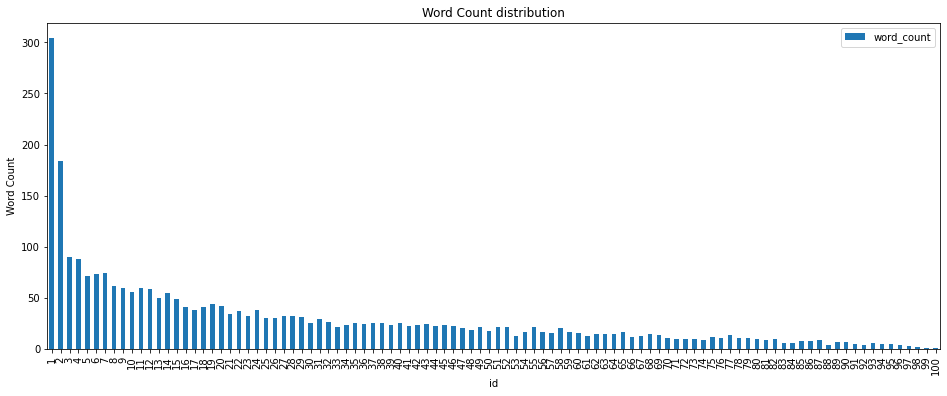

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

df_plot.set_index('id', inplace=True)
df_plot.plot(kind='bar', figsize=(16, 6))
plt.ylabel('Word Count')
plt.title('Word Count distribution')
plt.show()

In [15]:
!pip3 install textblob

In [16]:
from textblob import TextBlob
def sentiment_score(chat):
        return TextBlob(chat).sentiment.polarity

In [18]:
from pyspark.sql.types import FloatType
sentiment_score_udf = F.udf(lambda x: sentiment_score(x), FloatType())

In [24]:
df = df.select('id', 'label', 'chat','word_count',
                   sentiment_score_udf('chat').alias('sentiment_score'))
df.show()

+---+---------------+--------------------+----------+---------------+
| id|          label|                chat|word_count|sentiment_score|
+---+---------------+--------------------+----------+---------------+
|  1|       escalate|I had a friend th...|       304|    0.018961353|
|  2|       escalate|"My friend dealt ...|       184|     0.20601852|
|  3|       escalate|Friend who had bi...|        90|    0.008333334|
|  4|do_not_escalate|Over the internet...|        88|    0.045833334|
|  5|       escalate|Having gone throu...|        71|         0.0125|
|  6|       escalate|My now girlfriend...|        73|     0.06333333|
|  7|do_not_escalate|"Only really one ...|        74|    0.036363635|
|  8|do_not_escalate|Now that I've bee...|        62|          0.125|
|  9|do_not_escalate|I've always been ...|        60|           0.31|
| 10|       escalate|I feel completely...|        56|      -0.078125|
| 11|do_not_escalate|Took a week off w...|        60|     0.16666667|
| 12|       escalate

In [25]:
df.groupBy('label')\
    .agg(F.avg('sentiment_score').alias('avg_sentiment_score'))\
    .orderBy('avg_sentiment_score', ascending = False) \
    .show()

+---------------+--------------------+
|          label| avg_sentiment_score|
+---------------+--------------------+
|       escalate| 0.06338859780558519|
|do_not_escalate|0.031975071089198955|
+---------------+--------------------+



In [26]:
df = df.withColumn('words',F.split(F.col('chat'),' '))
df.show()

+---+---------------+--------------------+----------+---------------+--------------------+
| id|          label|                chat|word_count|sentiment_score|               words|
+---+---------------+--------------------+----------+---------------+--------------------+
|  1|       escalate|I had a friend th...|       304|    0.018961353|[I, had, a, frien...|
|  2|       escalate|"My friend dealt ...|       184|     0.20601852|["My, friend, dea...|
|  3|       escalate|Friend who had bi...|        90|    0.008333334|[Friend, who, had...|
|  4|do_not_escalate|Over the internet...|        88|    0.045833334|[Over, the, inter...|
|  5|       escalate|Having gone throu...|        71|         0.0125|[Having, gone, th...|
|  6|       escalate|My now girlfriend...|        73|     0.06333333|[My, now, girlfri...|
|  7|do_not_escalate|"Only really one ...|        74|    0.036363635|["Only, really, o...|
|  8|do_not_escalate|Now that I've bee...|        62|          0.125|[Now, that, I've,...|

In [27]:
stop_words = ['i','me','my','myself','we','our','ours','ourselves',
              'you','your','yours','yourself','yourselves','he','him',
              'his','himself','she','her','hers','herself','it','its',
              'itself','they','them','their','theirs','themselves',
              'what','which','who','whom','this','that','these','those',
              'am','is','are','was','were','be','been','being','have',
              'has','had','having','do','does','did','doing','a','an',
              'the','and','but','if','or','because','as','until','while',
              'of','at','by','for','with','about','against','between',
              'into','through','during','before','after','above','below',
              'to','from','up','down','in','out','on','off','over','under',
              'again','further','then','once','here','there','when','where',
              'why','how','all','any','both','each','few','more','most',
              'other','some','such','no','nor','not','only','own','same',
              'so','than','too','very','can','will','just','don','should','now']

In [28]:
from pyspark.ml.feature import StopWordsRemover

In [29]:
stopwordsRemovalFeature = StopWordsRemover(inputCol="words", 
                                           outputCol="words without stop").setStopWords(stop_words)

In [30]:
from pyspark.ml import Pipeline
stopWordRemovalPipeline = Pipeline(stages=[stopwordsRemovalFeature])
pipelineFitRemoveStopWords = stopWordRemovalPipeline.fit(df)

In [31]:
df = pipelineFitRemoveStopWords.transform(df)
df.select('words', 'words without stop').show(5)

+--------------------+--------------------+
|               words|  words without stop|
+--------------------+--------------------+
|[I, had, a, frien...|[friend, would, g...|
|["My, friend, dea...|["My, friend, dea...|
|[Friend, who, had...|[Friend, big, add...|
|[Over, the, inter...|[internet, LOT, p...|
|[Having, gone, th...|[gone, depression...|
+--------------------+--------------------+
only showing top 5 rows



In [33]:
df.select('words', 'words without stop').show(40)

+--------------------+--------------------+
|               words|  words without stop|
+--------------------+--------------------+
|[I, had, a, frien...|[friend, would, g...|
|["My, friend, dea...|["My, friend, dea...|
|[Friend, who, had...|[Friend, big, add...|
|[Over, the, inter...|[internet, LOT, p...|
|[Having, gone, th...|[gone, depression...|
|[My, now, girlfri...|[girlfriend, used...|
|["Only, really, o...|["Only, really, o...|
|[Now, that, I've,...|[I've, it,, altho...|
|[I've, always, be...|[I've, always, go...|
|[I, feel, complet...|[feel, completely...|
|[Took, a, week, o...|[Took, week, work...|
|[One, of, my, bes...|[One, best, frien...|
|[I've, had, some,...|[I've, friends, c...|
|[Haha., In, eight...|[Haha., eight, gr...|
|[Some, of, my, fr...|[friends, gone, t...|
|[I, feel, like, d...|[feel, like, depr...|
|[i've, had, a, co...|[i've, couple, fr...|
|[I, will, always,...|[always, listen.,...|
|[A, lot, for, my,...|[lot, friends., g...|
|[When, my, friend...|[friend, n

In [34]:
label = F.udf(lambda x: 1.0 if x == 'escalate' else 0.0, FloatType())
df = df.withColumn('label', label('label'))

In [35]:
df.select('label').show()

+-----+
|label|
+-----+
|  1.0|
|  1.0|
|  1.0|
|  0.0|
|  1.0|
|  1.0|
|  0.0|
|  0.0|
|  0.0|
|  1.0|
|  0.0|
|  1.0|
|  1.0|
|  0.0|
|  0.0|
|  1.0|
|  1.0|
|  1.0|
|  0.0|
|  0.0|
+-----+
only showing top 20 rows



In [36]:
import pyspark.ml.feature as feat
TF_ = feat.HashingTF(inputCol="words without stop", 
                     outputCol="rawFeatures", numFeatures=100000)
IDF_ = feat.IDF(inputCol="rawFeatures", outputCol="features")

In [37]:
pipelineTFIDF = Pipeline(stages=[TF_, IDF_])

In [38]:
pipelineFit = pipelineTFIDF.fit(df)
df = pipelineFit.transform(df)

In [39]:
df.select('label', 'rawFeatures','features').show()

+-----+--------------------+--------------------+
|label|         rawFeatures|            features|
+-----+--------------------+--------------------+
|  1.0|(100000,[394,796,...|(100000,[394,796,...|
|  1.0|(100000,[2543,428...|(100000,[2543,428...|
|  1.0|(100000,[5055,821...|(100000,[5055,821...|
|  0.0|(100000,[3199,337...|(100000,[3199,337...|
|  1.0|(100000,[3199,101...|(100000,[3199,101...|
|  1.0|(100000,[12080,14...|(100000,[12080,14...|
|  0.0|(100000,[2795,845...|(100000,[2795,845...|
|  0.0|(100000,[3199,357...|(100000,[3199,357...|
|  0.0|(100000,[3765,478...|(100000,[3765,478...|
|  1.0|(100000,[12335,13...|(100000,[12335,13...|
|  0.0|(100000,[13048,13...|(100000,[13048,13...|
|  1.0|(100000,[3199,578...|(100000,[3199,578...|
|  1.0|(100000,[3199,107...|(100000,[3199,107...|
|  0.0|(100000,[1129,675...|(100000,[1129,675...|
|  0.0|(100000,[781,796,...|(100000,[781,796,...|
|  1.0|(100000,[12335,16...|(100000,[12335,16...|
|  1.0|(100000,[3199,605...|(100000,[3199,605...|


In [40]:
(trainingDF, testDF) = df.randomSplit([0.75, 0.25], seed = 1234)

In [41]:
from pyspark.ml.classification import LogisticRegression
logreg = LogisticRegression(regParam=0.025)

In [48]:
logregModel = logreg.fit(trainingDF)

In [49]:
predictionDF = logregModel.transform(testDF)

In [50]:
predictionDF.select('label', 'probability', 'prediction').show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|  1.0|[0.41468693656149...|       1.0|
|  1.0|[0.69940061446988...|       0.0|
|  0.0|[0.78547787109961...|       0.0|
|  0.0|[0.86854814027744...|       0.0|
|  0.0|[0.79535014532056...|       0.0|
|  0.0|[0.63198377097935...|       0.0|
|  0.0|[0.92180640086346...|       0.0|
|  0.0|[0.98669525380904...|       0.0|
|  1.0|[0.54625188308162...|       0.0|
|  0.0|[0.93749244398690...|       0.0|
|  1.0|[0.42786173261268...|       1.0|
|  0.0|[0.94740386695915...|       0.0|
|  1.0|[0.67112890888696...|       0.0|
|  0.0|[0.91043100929769...|       0.0|
|  0.0|[0.97228513283732...|       0.0|
|  0.0|[0.95492522695999...|       0.0|
|  0.0|[0.94463904076757...|       0.0|
|  0.0|[0.92087763824098...|       0.0|
|  0.0|[0.95093273989543...|       0.0|
|  1.0|[0.79295021752548...|       0.0|
+-----+--------------------+----------+
only showing top 20 rows



In [51]:
predictionDF.crosstab('label', 'prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  4|  2|
|             0.0| 24|  0|
+----------------+---+---+



In [52]:
from sklearn import metrics
actual = predictionDF.select('label').toPandas()
predicted = predictionDF.select('prediction').toPandas()

In [53]:
print('accuracy score: {}%'.format(round(metrics.accuracy_score(actual, predicted),3)*100))

accuracy score: 86.7%


In [54]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

scores = predictionDF.select('label', 'rawPrediction')
evaluator = BinaryClassificationEvaluator()
print('The ROC score is {}%'.format(round(evaluator.evaluate(scores),3)*100))

The ROC score is 97.2%


In [55]:
predictionDF.describe('label').show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|                30|
|   mean|               0.2|
| stddev|0.4068381021724861|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+

